In [1]:
import pickle
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def compute_rho(phi_fuz: float, phi_exact: dict, n_extrapol_large=3):
    '''
    n_extrapol_large: the number of largest exact duplicates to use for extrapolation beyond max
                      if 1, this can be quite sensitive to noise, so default is 3
    '''

    lambda_ = None
    max_key = max(phi_exact.keys())
    
    # first if the target is smaller than the smallest for exact
    if phi_fuz <= phi_exact[1]:
        lambda_ = 1
        neq = lambda_ + (phi_fuz - phi_exact[lambda_]) / (phi_exact[lambda_+1] - phi_exact[lambda_])
        neq = max(1.0, neq)
    
    # then if the target is larger than the largest for exact, extrapolate
    elif phi_fuz >= phi_exact[max_key]:
        
        n0 = max_key - n_extrapol_large
        slope = np.mean([np.abs(phi_exact[i + 1] - phi_exact[i]) for i in range(n0, max_key)])
        neq = max_key + (phi_fuz - phi_exact[max_key]) / slope 
        
        #lambda_ = max_key
        #neq = lambda_ + (phi_fuz - phi_exact[lambda_]) / (phi_exact[lambda_] - phi_exact[lambda_ - 1])
    
    # do interpolation otherwise
    else:
        for n in range(1, max_key):
            if phi_exact[n] <= phi_fuz and phi_exact[n+1] >= phi_fuz:
                lambda_ = n
        neq = lambda_ + (phi_fuz - phi_exact[lambda_]) / (phi_exact[lambda_ + 1] - phi_exact[lambda_])
    
    # return the normalized value (assuming n_dup=10)
    return (neq - 1) / 9.0
  
def smooth_curve(nrep_aucs, mia = 'ratio', window_size=3):
    
    original_values =  [np.mean(nrep_aucs[n][mia]) for n in range(1, max(nrep_aucs.keys()) + 1)]

    # Apply a moving average with a window of 3
    smoothed_values = np.convolve(original_values, np.ones(window_size) / window_size, mode='valid')

    # Extend smoothed values to match original length
    smoothed_values = np.concatenate(([original_values[0]], smoothed_values, [original_values[-1]]))
        
    return {n:smoothed_values[i] for i, n in enumerate(range(1,max(nrep_aucs.keys())+1))}

## Now let's do it for vary k

In [3]:
all_Rs = [1, 5, 10, 15, 20, 25, 50, 75]

k=10, R=1, mean rho=0.898 +/- 0.031
k=10, R=5, mean rho=0.781 +/- 0.022
k=10, R=10, mean rho=0.646 +/- 0.021
k=10, R=15, mean rho=0.520 +/- 0.036
k=10, R=20, mean rho=0.452 +/- 0.038
k=10, R=25, mean rho=0.401 +/- 0.018
k=10, R=50, mean rho=0.186 +/- 0.011
k=10, R=75, mean rho=0.081 +/- 0.013
k=100, R=1, mean rho=0.920 +/- 0.049
k=100, R=5, mean rho=0.728 +/- 0.029
k=100, R=10, mean rho=0.585 +/- 0.030
k=100, R=15, mean rho=0.490 +/- 0.017
k=100, R=20, mean rho=0.410 +/- 0.017
k=100, R=25, mean rho=0.341 +/- 0.020
k=100, R=50, mean rho=0.147 +/- 0.012
k=100, R=75, mean rho=0.053 +/- 0.008
k=1000, R=1, mean rho=0.948 +/- 0.034
k=1000, R=5, mean rho=0.736 +/- 0.034
k=1000, R=10, mean rho=0.588 +/- 0.021
k=1000, R=15, mean rho=0.449 +/- 0.031
k=1000, R=20, mean rho=0.363 +/- 0.021
k=1000, R=25, mean rho=0.305 +/- 0.018
k=1000, R=50, mean rho=0.117 +/- 0.011
k=1000, R=75, mean rho=0.037 +/- 0.004
k=random, R=1, mean rho=0.909 +/- 0.028
k=random, R=5, mean rho=0.726 +/- 0.044
k=random, R=10

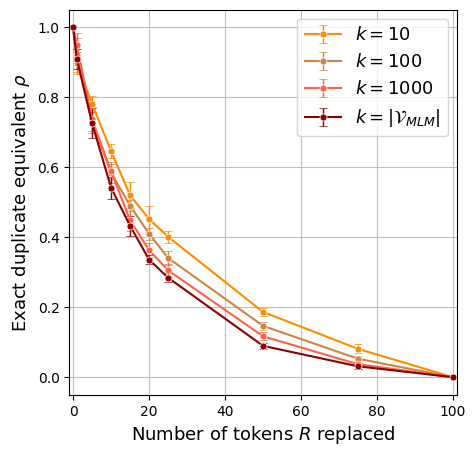

In [ ]:
mia = 'ratio'
seeds = [1, 2, 3, 4, 5]

plt.figure(figsize = (5, 5))

# now let's do the same but for varying k
colors = ["darkorange", "peru", "tomato", "darkred"]

for i, k in enumerate((10, 100, 1000, 'random')):
    
    all_rhos = {R:[] for R in all_Rs}
    
    for seed in seeds:
        
        exact_path = f"SOME_DATA_DIR/nrep_aucs_gptneo1B_exactduplicates_gpt_seed{seed}_lr2e5.pickle"
         
        with open(exact_path, "rb") as f:
            nrep_aucs = pickle.load(f)
            
        all_phi_exact = smooth_curve(nrep_aucs, mia=mia, window_size=3)
        
        # load the shuffle results
        near_dups_path = f"SOME_DATA_DIR/R_aucs_gptneo1B_nearduplicates_diffindices_topk{k}_gpt_RXX_seed{seed}_lr2e5.pickle"
        
        with open(near_dups_path, "rb") as f:
            near_dups_results = pickle.load(f)
            
        for R in all_Rs:
            all_rhos[R].append(compute_rho(phi_fuz=near_dups_results[R][mia], phi_exact=all_phi_exact))
       
    mean_rhos = [np.mean(all_rhos[R]) for R in all_Rs]    
    std_rhos = [np.std(all_rhos[R]) for R in all_Rs]
    
    for R in all_Rs:
        print(f"k={k}, R={R}, mean rho={np.mean(all_rhos[R]):.3f} +/- {np.std(all_rhos[R]):.3f}")
         
    if k == 'random':
        label = r"$k=|\mathcal{V}_{MLM}|$"
    else:
        label = rf"$k={k}$"
    
    plt.errorbar([0] + all_Rs + [100], 
             [1] + mean_rhos + [0],
             yerr=[0] + std_rhos + [0],
             fmt='-o', 
             color=colors[i], 
             markersize=5,
             markeredgecolor='white', 
             markerfacecolor=colors[i], 
             markeredgewidth=0.5,
             capsize=3,  # adds caps to error bars
             capthick=1,
             elinewidth=1,
             label=label)

plt.xlabel(r'Number of tokens $R$ replaced', fontsize = 13)
plt.ylabel(r"Exact duplicate equivalent $\rho$", fontsize = 13)
plt.legend(fontsize = 13)
plt.grid(alpha = 0.8)
plt.ylim(-0.05, 1.05)
plt.xlim(-1, 101)
plt.show()